In [91]:
# Data Cleaning and analysis packages
import pandas as pd
import numpy as np


# NLP packages
from nltk.corpus import stopwords



# Sats and Modeling packages
from sklearn import metrics
from scipy import stats
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression


# Visualization packages
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="dark")
sns.set(style="whitegrid", color_codes=True)

import pickle
import warnings
warnings.filterwarnings("ignore") 


pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 200)

In [16]:
filename = "modeling_df"

In [17]:
infile = open(filename,"rb")
df = pickle.load(infile)
infile.close()

In [18]:
df.head(2)

,item_name,price,overall_rating,num_rating,recommend,rev_title,review_text,section,target,rating_bin,clean_rev_title,clean_review_text,tokenized,rem_stop,lemma_words,delisted,girls',men's,women's,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,Wrangler Men's Unlined Shirt Jacket,12.0,4.0,7.0,80.0,['Texas winter ready!'],['I bought this last year and am going to buy ...,men's clothing,0,1,texas winter ready,i bought this last year and am going to buy an...,"[i, bought, this, last, year, and, am, going, ...","[bought, last, year, going, buy, another, frid...","[bought, last, year, going, buy, another, frid...","bought, last, year, going, buy, another, frida...",0.0,1.0,0.0,0.011114,0.011114,0.011114,0.899972,0.011114,0.011114,0.011114,0.011114,0.011114,0.011114
1,Wrangler Men's Relaxed Fit Jeans,12.0,4.5,5840.0,90.0,"['Wrangler is the best.', 'My Favorite Jeans',...","['I like wrangler, the pants is exactly for my...",men's clothing,1,1,wrangler is the best my favorite jeans extreme...,i like wrangler the pants is exactly for my bo...,"[i, like, wrangler, the, pants, is, exactly, f...","[like, wrangler, pants, exactly, body, also, g...","[like, wrangler, pant, exactly, body, also, go...","like, wrangler, pant, exactly, body, also, goo...",0.0,1.0,0.0,0.000000,0.000000,0.000000,0.998059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
df.isna().sum()

item_name            0
price                0
overall_rating       0
num_rating           0
recommend            0
rev_title            0
review_text          0
section              0
target               0
rating_bin           0
clean_rev_title      0
clean_review_text    0
tokenized            0
rem_stop             0
lemma_words          0
delisted             0
girls'               0
men's                0
women's              0
topic0               0
topic1               0
topic2               0
topic3               0
topic4               0
topic5               0
topic6               0
topic7               0
topic8               0
topic9               0
dtype: int64

# Train Test Split


In [20]:
drop_features = ["item_name", "overall_rating", "rating_bin", "recommend", "rev_title", "clean_rev_title", 
                 "clean_review_text", "review_text", "section", "tokenized", "rem_stop", "lemma_words", 
                 "target"]

In [21]:
X = df.drop(columns = drop_features)
y = df["target"].values

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [23]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(919, 16) (919,) (230, 16) (230,)


# TfidfVectorizer

In [25]:
# Extracted the stopwords from my preprocessing notebook to be used for the TfidfVectorizer
eda_stopwords = ["nd", "de", "c", "great", "wow", "must", "six", "goat", "thou", "un", "lb", "pair", "right", "x", "xl", "one", "way", "definitely", "shirt", "jacket", "daughter", "son" ]

stop_words=list(set(stopwords.words("english")))

stop_words.extend(eda_stopwords)

In [26]:
tfidfvec = TfidfVectorizer(stop_words = stop_words, ngram_range = (1,2), max_features=2000, use_idf=True)  


train_vec = tfidfvec.fit_transform(X_train.delisted.values).toarray()
test_vec = tfidfvec.fit_transform(X_test.delisted.values).toarray()



tfidf_train = pd.DataFrame(train_vec, columns = tfidfvec.get_feature_names())
tfidf_test = pd.DataFrame(test_vec, columns = tfidfvec.get_feature_names())

In [33]:
print(f"X train shape: {X_train.shape}, Tfidf train shape: {tfidf_train.shape}") 
print("-"*20)
print(f"X test shape: {X_test.shape}, Tfidf test shape: {tfidf_test.shape}")

X train shape: (919, 16), Tfidf train shape: (919, 2000)
--------------------
X test shape: (230, 16), Tfidf test shape: (230, 2000)


In [34]:
# resetting index to concatenate with tfidf. Resetting index will not affect the dataset. 
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [35]:
frame1 = [X_train, tfidf_train]
frame2 = [X_test, tfidf_test]

X_train = pd.concat(frame1, axis=1)
X_test = pd.concat(frame2, axis=1)

In [36]:
X_train.head(2)

,price,num_rating,delisted,girls',men's,women's,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,able,able wear,absolutely,absolutely adorable,absolutely love,absolutely loved,acceptable,accessory,according,accurate,across,active,activity,actual,actually,add,added,addition,adjust,adjustable,adjustable waist,adorable,adult,advertised,affordable,age,ago,air,air dry,allow,almost,almost like,alone,along,already,also,also comfortable,also like,also love,also ordered,also run,also soft,although,always,always worn,amazing,american,amount,amount stretch,ankle,annoying,another,another brand,another different,anymore,anyone,anything,anything like,anyway,anywhere,apart,appear,appearance,appears,appreciate,appropriate,aqua,area,arm,armhole,armpit,around,around ankle,around house,arrive,arrived,arrived quickly,ask,athletic,athletic workout,attractive,available,average,avia,away,awesome,awful,awkward,baby,back,back pocket,back school,bad,bag,baggy,ball,band,bar,barely,bargain,based,baselayer,baselayer cool,basic,basically,batch,bathrobe,battery,bc,beat,beat price,beautiful,beautiful dress,beautifully,become,bed,behind,believe,belly,belt,bend,bending,best,best fitting,best thing,better,better expected,beware,beyond,bib,big,big deal,big enough,big wear,...,washed well,washed yet,washer,washing,washing machine,waste,waste money,watch,water,water resistant,wear,wear also,wear anything,wear around,wear bra,wear day,wear dress,wear large,wear love,wear medium,wear ordered,wear pant,wear school,wear shoe,wear skirt,wear time,wear wear,wear well,wear work,wear would,wearable,wearing,wearing bra,weather,website,week,weekend,weigh,weight,weight fabric,weird,well,well comfortable,well constructed,well done,well good,well like,well look,well love,well made,well nice,well perfect,well true,well worth,went,went back,wet,whatever,white,whole,wide,wider,width,wife,win,wind,winter,winter coat,winter month,wire,wish,wish came,wish color,wish could,wish would,within,without,woman,wonder,wonder long,wonder nation,wonderful,wonderfully,wont,word,wore,work,work well,worked,working,workout,workout running,world,worn,worried,worst,worth,worth money,worth price,would,would big,would buy,would even,would get,would go,would like,would look,would love,would make,would never,would nice,would order,would probably,would purchase,would recommend,would say,would suggest,would wear,wrangler,wrangler jean,wrap,wrap around,wrap dress,wrinkle,wrinkled,wrist,write,writing,wrong,wrote,xa,xxl,yard,yeah,year,year ago,year always,year love,year old,yellow,yes,yesterday,yet,yo,younger,yr,yr old,zero,zip,zipper
0,11.94,13.0,"thick, material, quality, product, price, good...",1.0,0.0,0.0,0.0,0.0,0.0,0.977495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157579,0.0,0.0,0.0,0.0,0.090226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.062289,0.144165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.09364,0.0,0.0,0.0,0.0,0.0,0.071991,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.00,3.0,"hoodie, little, thinner, side, daughter, love,..."

In [37]:
X_train.drop(columns = ["delisted"], inplace = True)
X_test.drop(columns = "delisted", inplace=True)

# Logistic Regression

In [40]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg_clf = LogisticRegression(penalty = "l2", random_state = 0,n_jobs=-1)
logreg_clf.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=0)

In [41]:
y_pred_lr = logreg_clf.predict(X_test)
print("F1 score is:", metrics.f1_score(y_test, y_pred_lr))
print("-"*60)                         
print(classification_report(y_test, y_pred_lr))

F1 score is: 0.8235294117647058
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.15      0.23        67
           1       0.73      0.94      0.82       163

    accuracy                           0.71       230
   macro avg       0.63      0.55      0.53       230
weighted avg       0.67      0.71      0.65       230



# Bernoulli Naive Bayes


In [42]:
B_nb = BernoulliNB(alpha=0.1)
B_nb.fit(X_train, y_train)

BernoulliNB(alpha=0.1)

In [43]:
y_pred_Bnb = B_nb.predict(X_test)
BNB_cm = confusion_matrix(y_test, y_pred_Bnb)
print("F1 score is:", metrics.f1_score(y_test, y_pred_Bnb))
print("-"*60)                         
print(classification_report(y_test, y_pred_Bnb))

F1 score is: 0.8202247191011235
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.54      0.30      0.38        67
           1       0.76      0.90      0.82       163

    accuracy                           0.72       230
   macro avg       0.65      0.60      0.60       230
weighted avg       0.69      0.72      0.69       230



# Random Forest Classifier

In [46]:
rfc_classifier = RandomForestClassifier(n_estimators = 300, criterion = "entropy", random_state = 0)

In [47]:
rfc_classifier.fit(X_train, y_train)
y_pred_RF = rfc_classifier.predict(X_test)
print("F1 score is:", metrics.f1_score(y_test, y_pred_RF))
print("-"*100)                         
print(classification_report(y_test, y_pred_RF))
print("-"*100)
RFC_cm = confusion_matrix(y_test, y_pred_RF)
print(RFC_cm)

F1 score is: 0.8189415041782729
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.27      0.36        67
           1       0.75      0.90      0.82       163

    accuracy                           0.72       230
   macro avg       0.64      0.59      0.59       230
weighted avg       0.69      0.72      0.68       230

----------------------------------------------------------------------------------------------------
[[ 18  49]
 [ 16 147]]


# GridSearchCV with Random Forest Classifier

In [67]:
rfc = RandomForestClassifier(n_estimators = 300, criterion = "entropy",
                             random_state = 0, verbose=1, n_jobs=-1, class_weight="balanced")

In [68]:
param_dict={'min_samples_leaf':range(1,10,1), 'max_depth': range(1,10,1), "max_leaf_nodes":range(5,11,1)}

In [69]:
grid_tree = GridSearchCV(rfc, param_dict, cv=10, scoring="f1", verbose=2, n_jobs=-1)
grid_tree.fit(X_train, y_train)


Fitting 10 folds for each of 486 candidates, totalling 4860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 4860 out of 4860 | elapsed: 20.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              criterion='entropy',
                                              n_estimators=300, n_jobs=-1,
                                              random_state=0, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 10),
                         'max_leaf_nodes': range(5, 11),
                         'min_samples_leaf': range(1, 10)},
             scoring='f1', verbose=2)

In [70]:
grid_tree_pred = grid_tree.predict(X_test)
print("F1 score is:", metrics.f1_score(y_test, grid_tree_pred))
print("-"*60)                         
print(classification_report(y_test, grid_tree_pred))
print("-"*100)
Grid_cm = confusion_matrix(y_test, grid_tree_pred)
print(Grid_cm)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


F1 score is: 0.8235294117647058
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.56      0.30      0.39        67
           1       0.76      0.90      0.82       163

    accuracy                           0.73       230
   macro avg       0.66      0.60      0.61       230
weighted avg       0.70      0.73      0.70       230

----------------------------------------------------------------------------------------------------
[[ 20  47]
 [ 16 147]]


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished


In [71]:
print(grid_tree.best_params_)
print("-"*100)
print(grid_tree.best_estimator_)
print("-"*100)
print(grid_tree.best_estimator_.feature_importances_)

{'max_depth': 4, 'max_leaf_nodes': 10, 'min_samples_leaf': 1}
----------------------------------------------------------------------------------------------------
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, max_leaf_nodes=10, n_estimators=300,
                       n_jobs=-1, random_state=0, verbose=1)
----------------------------------------------------------------------------------------------------
[4.05085090e-03 2.78567173e-03 3.70329177e-04 ... 8.22481905e-04
 1.66197401e-04 7.60665658e-05]


# GridSearchCV with Logistic Regression

In [55]:
logreg = LogisticRegression(random_state = 0, n_jobs=-1, verbose=2)
log_dict = {'tol': [8,9,10,11,12], 'C': [1,5], 'penalty': ["l1", "l2"]}

In [56]:
grid_log = GridSearchCV(logreg, log_dict, cv=5, scoring="f1", verbose=2, n_jobs=-1)


grid_log.fit(X_train, y_train)
#rfc.fit(X_train_tfidf, y_train_tfidf)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


GridSearchCV(cv=5,
             estimator=LogisticRegression(n_jobs=-1, random_state=0, verbose=2),
             n_jobs=-1,
             param_grid={'C': [1, 5], 'penalty': ['l1', 'l2'],
                         'tol': [8, 9, 10, 11, 12]},
             scoring='f1', verbose=2)

In [57]:
grid_log_pred = grid_log.predict(X_test)
print("F1 score is:", metrics.f1_score(y_test, grid_log_pred))
print("-"*60)                         
print(classification_report(y_test, grid_log_pred))
print("-"*100)
Grid_cm = confusion_matrix(y_test, grid_log_pred)
print(Grid_cm)

F1 score is: 0.8235294117647058
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.15      0.23        67
           1       0.73      0.94      0.82       163

    accuracy                           0.71       230
   macro avg       0.63      0.55      0.53       230
weighted avg       0.67      0.71      0.65       230

----------------------------------------------------------------------------------------------------
[[ 10  57]
 [  9 154]]


In [74]:
print(grid_log.best_params_)
print("-"*100)
print(grid_log.best_estimator_)


{'C': 1, 'penalty': 'l2', 'tol': 8}
----------------------------------------------------------------------------------------------------
LogisticRegression(C=1, n_jobs=-1, random_state=0, tol=8, verbose=2)


# Overall Scores

In [73]:
# Logistic Regression:
print("Logistic Regression F1 score is:", metrics.f1_score(y_test, y_pred_lr))
# Multinominal NB
print("Bernoulli F1 score is:", metrics.f1_score(y_test, y_pred_Bnb))
# Random Forest
print("Random Forest F1 score is:", metrics.f1_score(y_test, y_pred_RF))
# Grid Search - Random Forest
print("GridSearchCV w/ Random Forest F1 score is:", metrics.f1_score(y_test, grid_tree_pred))
# Grid Search - Logistic Regression
print("GridSearchCV w/ Random Forest F1 score is:", metrics.f1_score(y_test, grid_log_pred))

Logistic Regression F1 score is: 0.8235294117647058
Bernoulli F1 score is: 0.8202247191011235
Random Forest F1 score is: 0.8189415041782729
GridSearchCV w/ Random Forest F1 score is: 0.8235294117647058
GridSearchCV w/ Random Forest F1 score is: 0.8235294117647058


# Feature Importances

### Feature Importance from Logistic Regression

In [77]:
print(logreg_clf.coef_)

[[-2.55652334e-02 -1.13937588e-04 -9.78507683e-01 ... -2.25938705e-01
   8.86523487e-02  3.00885493e-01]]


In [78]:
def get_coef_name(fit_model, df):
    temp = (list(zip(fit_model.coef_[0], df.columns)))
    return sorted(temp,key = lambda x: x[0], reverse=True)

In [80]:
log_reg_coef=pd.DataFrame(get_coef_name(logreg_clf, X_train), columns = ["coefficient", "feature"])

In [81]:
# top 5 (positive) and Bottom 5 (negative) gives you the 5 most positve and 5 most negative values. 
top5_coef = pd.concat([log_reg_coef.head(),log_reg_coef.tail()])

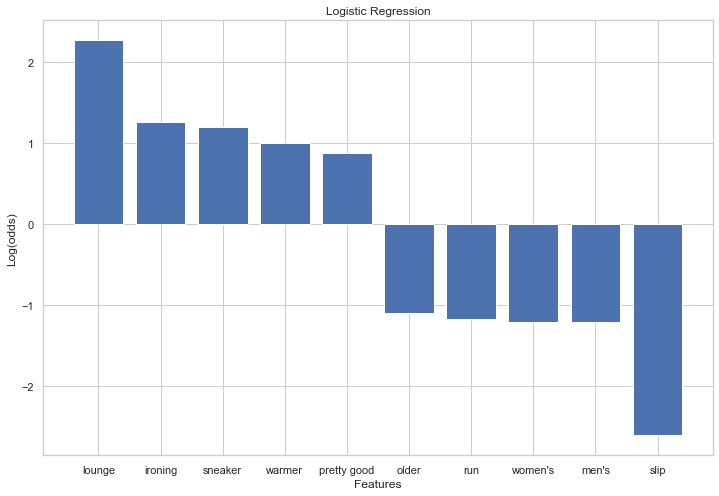

In [92]:
fig, ax = plt.subplots(figsize = (12,8))
plt.bar(x = top5_coef.feature, height=top5_coef.coefficient)
plt.title("Logistic Regression")
plt.xlabel("Features")
plt.ylabel("Log(odds)");

### Feature Importance from Random Forest

In [59]:
d={'Stats':X.columns,'FI':grid_tree.best_estimator_.feature_importances_}

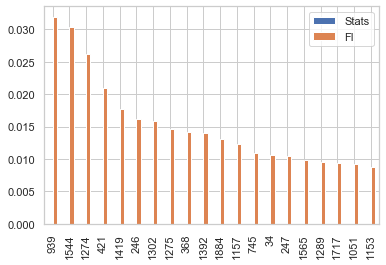

In [93]:
data = pd.DataFrame.from_dict(d, orient="index")
data = data.transpose()
data = data.sort_values(by='FI', ascending=False)
data[:20].plot(kind="bar")

In [61]:
data.drop(columns="Stats", inplace=True)
data.reset_index(inplace=True)

In [62]:
data.rename(columns={"index":"Stats"}, inplace=True)

In [63]:
feat_imp=data[:10].sort_values(by='FI', ascending=False)

In [64]:
feat_imp

,Stats,FI
0,939,0.0319694
1,1544,0.0304011
2,1274,0.0261771
3,421,0.0209456
4,1419,0.0177726
5,246,0.0161024
6,1302,0.0158668
7,1275,0.0145786
8,368,0.0141111
9,1392,0.0140277


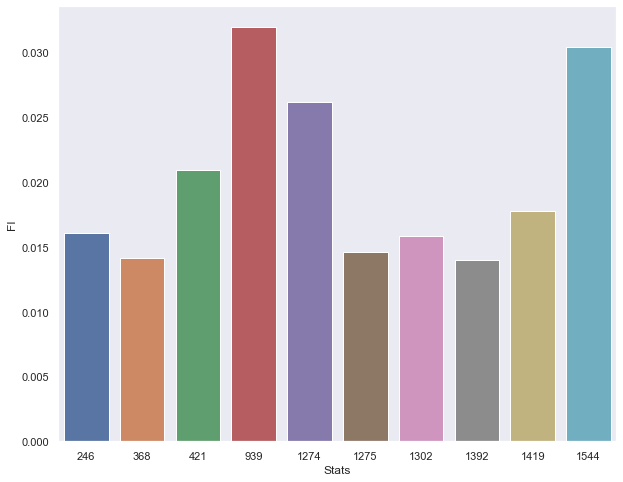

In [89]:
x=feat_imp.Stats
y=feat_imp.FI

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=x, y=y, data = feat_imp)